<a href="https://colab.research.google.com/github/andrewsiyoon/spiking-seRNN/blob/main/Standard_SNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 1.7 MB/s 


In [ ]:
# Imports ---------------
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

SETTING UP MNIST

In [ ]:
# Dataloader arguments ---------------
batch_size = 128
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# Define a transformation ---------------
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [ ]:
# Create DataLoaders ---------------
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

NETWORK ARCHITECTURE

In [ ]:
# Network Architecture ---------------
num_inputs = 28*28 #We transformed the MNIST dataset to dimensions (28,28) in above code
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [ ]:
# Define Network ---------------
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden) #Applies a linear transformation of all pixels from MNIST (inputs)
        self.lif1 = snn.Leaky(beta=beta) #First spiking neuron layer: integrates weighted input over time and emits a spike if threshold is met
        self.fc2 = nn.Linear(num_hidden, num_outputs) #Applies a linear transformation to the output spikes of fc1
        self.lif2 = snn.Leaky(beta=beta) #Second spiking neuron layer: integrates weighted spikes over time

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net().to(device)

TRAINING THE SNN

1. Accuracy metric: from a batch of data passed through the network, sum all the spikes from each neuron over time and compare the index of the highest spike count to that of the target. If they match, the network correctly predicted the target. This is a way of assessing the accuracy of the network.

In [ ]:
# Accuracy calculator and print function ---------------
# The first function calculates the batch accuracy, by passing data into the network and summating the spikes per neuron.
# Then, it compares the highest sum (index) with the actual target to calculate accuracy.
# The second function will be called later to report the epoch/iteration #, train set loss, test set loss, and accuracy measures.

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

2. Define the loss function

In [ ]:
# Loss function ---------------

loss = nn.CrossEntropyLoss() 

#Single PyTorch function that takes the softmax of the output layer and generates a loss at the output 
#(see Pytorch documentation for possible parameters)

3. Define the optimizer (Adam for this example)

In [ ]:
# Adam optimizer ---------------

optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

#Can adjust the learning rate (lr), and the betas as well?

4. Training loop

In [ ]:
# Training paradigm ---------------

num_epochs = 1 #Modify if you want to train for >1 epoch
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch: #taking a batch of data and loading it into CUDA
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1)) #flatten the input data into a vector and pass it into the network
        #Batch_size was defined earlier as 784, then transformed into a 28*28
        #The input is taken across 25 time steps, 128 data samples, and 10 output neurons which you can see through print(mem_rec.size())

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device) #Initialize the total loss value
        for step in range(num_steps): #Sum loss at every step
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad() #Clear previously stored gradients
        loss_val.backward() #Calculate the gradients
        optimizer.step() #Weight update

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 60.91
Test Set Loss: 54.00
Train set accuracy for a single minibatch: 43.75%
Test set accuracy for a single minibatch: 24.22%


Epoch 0, Iteration 50
Train Set Loss: 14.17
Test Set Loss: 12.40
Train set accuracy for a single minibatch: 88.28%
Test set accuracy for a single minibatch: 87.50%


Epoch 0, Iteration 100
Train Set Loss: 8.66
Test Set Loss: 8.54
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 92.19%


Epoch 0, Iteration 150
Train Set Loss: 11.02
Test Set Loss: 13.09
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 91.41%


Epoch 0, Iteration 200
Train Set Loss: 8.71
Test Set Loss: 5.85
Train set accuracy for a single minibatch: 92.97%
Test set accuracy for a single minibatch: 96.88%


Epoch 0, Iteration 250
Train Set Loss: 10.85
Test Set Loss: 4.75
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 96.88%


Epoch 

PLOT TRAIN/TEST LOSS CURVES

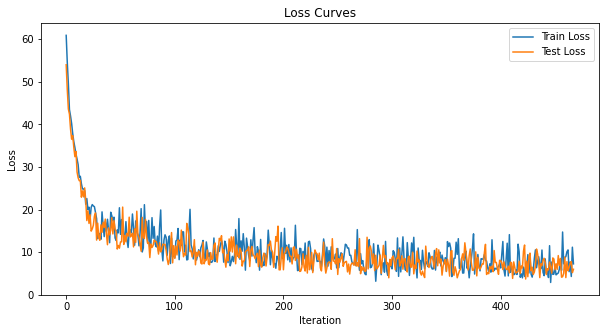

In [ ]:
# Plot Loss ---------------

fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

CALCULATE TEST SET ACCURACY

In [ ]:
# Calculate accuracy ---------------

total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9444/10000
Test Set Accuracy: 94.44%
